In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.stats
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.special import expit, logit
from scipy.stats import norm
from sklearn.naive_bayes import GaussianNB

import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

# Dataset

In [3]:
df = pd.read_csv("HeartFail/heart.csv")
df.drop('Sex', axis=1, inplace=True)
df.drop('Oldpeak', axis=1, inplace=True)
df.drop('ST_Slope', axis=1, inplace=True)
df

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,HeartDisease
0,40,ATA,140,289,0,Normal,172,N,0
1,49,NAP,160,180,0,Normal,156,N,1
2,37,ATA,130,283,0,ST,98,N,0
3,48,ASY,138,214,0,Normal,108,Y,1
4,54,NAP,150,195,0,Normal,122,N,0
...,...,...,...,...,...,...,...,...,...
913,45,TA,110,264,0,Normal,132,N,1
914,68,ASY,144,193,1,Normal,141,N,1
915,57,ASY,130,131,0,Normal,115,Y,1
916,57,ATA,130,236,0,LVH,174,N,1


## Missing Values?

In [4]:
missing = df.isnull().sum()
print(missing)

Age               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
HeartDisease      0
dtype: int64


## Changing Categorical Features to Numerical

In [5]:
char_cols = df.dtypes.pipe(lambda x: x[x == 'object']).index
label_mapping = {}

for c in char_cols:
    df[c], label_mapping[c] = pd.factorize(df[c])
    
df

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,HeartDisease
0,40,0,140,289,0,0,172,0,0
1,49,1,160,180,0,0,156,0,1
2,37,0,130,283,0,1,98,0,0
3,48,2,138,214,0,0,108,1,1
4,54,1,150,195,0,0,122,0,0
...,...,...,...,...,...,...,...,...,...
913,45,3,110,264,0,0,132,0,1
914,68,2,144,193,1,0,141,0,1
915,57,2,130,131,0,0,115,1,1
916,57,0,130,236,0,2,174,0,1


In [6]:
normalized_df=(df-df.mean())/df.std()
normalized_df['HeartDisease'] = df['HeartDisease']
normalized_df

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,HeartDisease
0,-1.432359,-1.704644,0.410685,0.824621,-0.551041,-0.748772,1.382175,-0.823108,0
1,-0.478223,-0.530703,1.490940,-0.171867,-0.551041,-0.748772,0.753746,-0.823108,1
2,-1.750404,-1.704644,-0.129442,0.769768,-0.551041,0.491973,-1.524307,-0.823108,0
3,-0.584238,0.643238,0.302660,0.138964,-0.551041,-0.748772,-1.131539,1.213585,1
4,0.051853,-0.530703,0.950812,-0.034736,-0.551041,-0.748772,-0.581664,-0.823108,0
...,...,...,...,...,...,...,...,...,...
913,-0.902283,1.817178,-1.209697,0.596068,-0.551041,-0.748772,-0.188897,-0.823108,1
914,1.536064,0.643238,0.626736,-0.053020,1.812770,-0.748772,0.164595,-0.823108,1
915,0.369898,0.643238,-0.129442,-0.619830,-0.551041,-0.748772,-0.856602,1.213585,1
916,0.369898,-1.704644,-0.129442,0.340090,-0.551041,1.732717,1.460728,-0.823108,1


In [8]:
d, d_test = train_test_split(normalized_df, test_size=0.25)

In [9]:
d.to_csv("heart_train.csv", header=False, index=False)

In [10]:
d_test.to_csv("heart_test.csv", header=False, index=False)

In [7]:
d = normalized_df.to_numpy()
X = d[:,:-1]
Y = d[:,-1]

## Train-Test Split

In [8]:
x, x_test, y, y_test = train_test_split(X, Y, test_size=0.25)
x.shape, x_test.shape, y.shape, y_test.shape

((688, 8), (230, 8), (688,), (230,))

## Normalising Dataset

In [28]:
scaler = preprocessing.StandardScaler().fit(X_train)
scaler.mean_, scaler.scale_

(array([ 53.24418605,   1.48546512, 132.74273256, 201.4244186 ,
          0.2369186 ,   0.60901163, 136.91424419,   0.39680233]),
 array([  9.61640561,   0.8403476 ,  19.05139406, 109.17171021,
          0.42519193,   0.80858774,  25.27470989,   0.48923434]))

In [29]:
X = scaler.transform(X_train)
X.mean(axis=0), X.std(axis=0)

(array([-1.58464972e-16,  6.64842858e-17,  5.75282716e-16,  1.51041970e-16,
         1.22963655e-16, -8.64941194e-17, -1.90093419e-16,  2.69487275e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1.]))

# Algorithms

## Bayes Classifier

In [21]:
model = GaussianNB()
model.fit(X, Y)

GaussianNB()

In [22]:
yPred = model.predict(Xtest)
correct = np.sum(yPred==Ytest)
print("Accuracy: ", correct/len(Ytest))

Accuracy:  0.5043478260869565


### Less Features

In [30]:
model = GaussianNB()
model.fit(X, Y)

yPred = model.predict(Xtest)
correct = np.sum(yPred==Ytest)
print("Accuracy: ", correct/len(Ytest))

Accuracy:  0.5478260869565217


## Logistic Regression (Newton Raphson)

In [131]:
def initialise_w(initialise):
    if(initialise == 'random'):
        w = np.random.randn(d,1)/10
        print("w is initialised from N[0,1]")
    elif(initialise == 'zeros'):
        w = np.zeros((d,1))
        print("w is initialised as a zero vector")
    else:
        print("Method unknown")
    return w

def compute_mu(X, w):
    mu = expit(np.dot(X,w))
    mu = mu.reshape(X.shape[0],1)
    return mu

def first_derivative(w):
    mu = compute_mu(X, w)
    epsilon = 1e-12

    grad = np.matmul(np.transpose(X), (mu-Y)) + w.reshape(d,1)
    grad = grad.squeeze()
    return(grad)

def second_deivative(w,X,y):
    mu = compute_mu(X, w)
    R = np.eye(n)
    for i in range(n):
        R[i,i] = mu[i,0] * (1-mu[i,0])
    return(np.dot(np.dot(np.transpose(X),R),X) + np.eye(d))

def test(w, X, y):
    n,d = X.shape
    mu = compute_mu(X, w)
    yhat = np.zeros((n,1)).astype(np.float64)
    yhat[mu>0.5]=1
    correct = np.sum(yhat==y)
    return(correct,n)

def train(initialise):

    np.random.seed(0)
    w = initialise_w(initialise)
    for j in range(100):

        grad1 = first_derivative(w.squeeze()).reshape(d,1)
        H = second_deivative(w, X, Y)
        delta_w = np.dot(np.linalg.inv(H),grad1)
        w = w - delta_w
        diff = np.linalg.norm(delta_w)

        correct,n = test(w, Xtest, Ytest)
        print("Iteration : {} \t Accuracy : {}%".format(j,correct/n*100))

        if(diff < 1e-5):
            print("tolerance reached at the iteration : ",j)
            break
    print("Training done...")
    print("Model weights : ", np.transpose(w))

n,d = X.shape
n1,d1 = Xtest.shape

Y = Y.reshape(n,1)
Ytest = Ytest.reshape(n1,1)

In [132]:
train('zeros')

w is initialised as a zero vector
Iteration : 0 	 Accuracy : 40.869565217391305%
Iteration : 1 	 Accuracy : 40.869565217391305%
Iteration : 2 	 Accuracy : 40.869565217391305%
Iteration : 3 	 Accuracy : 40.869565217391305%
Iteration : 4 	 Accuracy : 40.869565217391305%
Iteration : 5 	 Accuracy : 40.869565217391305%
tolerance reached at the iteration :  5
Training done...
Model weights :  [[-0.03326866 -0.5127731   0.68203272  0.04199804 -0.3172562   0.30101375
   0.02288527 -0.38568513  0.62637218  0.20231199  1.04643309]]


In [133]:
train('random')

w is initialised from N[0,1]
Iteration : 0 	 Accuracy : 40.869565217391305%
Iteration : 1 	 Accuracy : 40.869565217391305%
Iteration : 2 	 Accuracy : 40.869565217391305%
Iteration : 3 	 Accuracy : 40.869565217391305%
Iteration : 4 	 Accuracy : 40.869565217391305%
Iteration : 5 	 Accuracy : 40.869565217391305%
tolerance reached at the iteration :  5
Training done...
Model weights :  [[-0.03326866 -0.5127731   0.68203272  0.04199804 -0.3172562   0.30101375
   0.02288527 -0.38568513  0.62637218  0.20231199  1.04643309]]


### Removing columns

In [145]:
def initialise_w(initialise):
    if(initialise == 'random'):
        w = np.random.randn(d,1)/10
        print("w is initialised from N[0,1]")
    elif(initialise == 'zeros'):
        w = np.zeros((d,1))
        print("w is initialised as a zero vector")
    else:
        print("Method unknown")
    return w

def compute_mu(X, w):
    mu = expit(np.dot(X,w))
    mu = mu.reshape(X.shape[0],1)
    return mu

def first_derivative(w):
    mu = compute_mu(X, w)
    epsilon = 1e-12

    grad = np.matmul(np.transpose(X), (mu-Y)) + w.reshape(d,1)
    grad = grad.squeeze()
    return(grad)

def second_deivative(w,X,y):
    mu = compute_mu(X, w)
    R = np.eye(n)
    for i in range(n):
        R[i,i] = mu[i,0] * (1-mu[i,0])
    return(np.dot(np.dot(np.transpose(X),R),X) + np.eye(d))

def test(w, X, y):
    n,d = X.shape
    mu = compute_mu(X, w)
    yhat = np.zeros((n,1)).astype(np.float64)
    yhat[mu>0.5]=1
    correct = np.sum(yhat==y)
    return(correct,n)

def train(initialise):

    np.random.seed(0)
    w = initialise_w(initialise)
    for j in range(100):

        grad1 = first_derivative(w.squeeze()).reshape(d,1)
        H = second_deivative(w, X, Y)
        delta_w = np.dot(np.linalg.inv(H),grad1)
        w = w - delta_w
        diff = np.linalg.norm(delta_w)

        correct,n = test(w, Xtest, Ytest)
        print("Iteration : {} \t Accuracy : {}%".format(j,correct/n*100))

        if(diff < 1e-5):
            print("tolerance reached at the iteration : ",j)
            break
    print("Training done...")
    print("Model weights : ", np.transpose(w))

n,d = X.shape
n1,d1 = Xtest.shape

Y = Y.reshape(n,1)
Ytest = Ytest.reshape(n1,1)

train('random')

w is initialised from N[0,1]
Iteration : 0 	 Accuracy : 42.173913043478265%
Iteration : 1 	 Accuracy : 42.173913043478265%
Iteration : 2 	 Accuracy : 42.173913043478265%
Iteration : 3 	 Accuracy : 42.173913043478265%
Iteration : 4 	 Accuracy : 42.173913043478265%
tolerance reached at the iteration :  4
Training done...
Model weights :  [[ 0.08916873  0.75559468  0.08747335 -0.35199611  0.40731751  0.11405956
  -0.4523914   0.8352809 ]]


## Probit Regression (L-BFGS)

In [166]:
def initialise_w(initialise):
    if(initialise == 'random'):
        w = np.random.randn(d,1)/10
        print("w is initialised from N[0,1]")
    elif(initialise == 'zeros'):
        w = np.zeros((d,1))
        print("w is initialised as a zero vector")
    else:
        print("Method unknown")
    return w

def compute_mu(X, w):
    phi=np.dot(X,w)
    mu = norm.cdf(phi)
    mu = mu.reshape(X.shape[0],1)
    return mu

def first_derivative(w):
    mu = compute_mu(X, w)
    epsilon = 1e-12
    phi=np.dot(X,w)
    grad_mu = X*(scipy.stats.norm.pdf(phi,0,1).reshape(-1,1))
    return(np.sum((- Y*(1/(mu)) + (1-Y)*(1/(1+epsilon-mu)))*grad_mu,0) + w).squeeze()

def second_deivative(w,X,y):
    mu = compute_mu(X, w)
    R = np.eye(n)

    phi=np.dot(X,w)
    for i in range(n):
        t1 = (y[i] - mu[i,0])/(mu[i,0] * (1-mu[i,0]))
        t2 = scipy.stats.norm.pdf(phi[i,0],0,1)
        t3 = (1-y[i])/np.power(1-mu[i,0],2) + y[i]/np.power(mu[i,0],2)
        R[i,i] = t1*t2*np.dot(X[i],w) + t3*t2*t2

    return(np.dot(np.dot(np.transpose(X),R),X) + np.eye(d))

def neg_log_posterior(w):
    w=w.reshape(-1,1)
    epsilon = 1e-12
    mu = compute_mu(X, w)
    prob_1 = Y*np.log(mu+epsilon)
    prob_0 = (1-Y)*np.log(1-mu+epsilon)
    log_like = np.sum(prob_1) + np.sum(prob_0)
    w_norm = np.power(np.linalg.norm(w),2)
    neg_log_pos = -log_like+w_norm/2
    print("neg_log_posterior = {:.4f} \tlog_like = {:.4f} \tw_norm = {:.4f}".format(neg_log_pos, log_like, w_norm))
    return(neg_log_pos)

def test(w, X, y):
    n,d = X.shape
    mu = compute_mu(X, w)
    #print(mu.shape, n, d)
    yhat = np.zeros((n,1)).astype(np.float64)
    yhat[mu>0.5]=1
    correct = np.sum(yhat==y)
    return(correct,n)

n,d = X.shape
n1,d1 = Xtest.shape

Y = Y.reshape(n,1)
Ytest = Ytest.reshape(n1,1)

res = minimize(neg_log_posterior, initialise_w('random'), method='BFGS', jac=first_derivative,
               tol= 1e-5, options={'maxiter': 100})
correct,n = test(res.x, Xtest, Ytest)
print("\n_____________Model trained______________\n")
print("\nModel weights : ", res.x)
print("\n_____________Test Accuracy______________\n")

print("Accuracy : {}% ".format(correct/n*100))

res = minimize(neg_log_posterior, initialise_w('random'), method='BFGS', jac=first_derivative,
               tol= 1e-5, options={'maxiter': 100})
correct,n = test(res.x, Xtest, Ytest)
print("\n_____________Model trained______________\n")
print("\nModel weights : ", res.x)
print("\n_____________Test Accuracy______________\n")

print("Accuracy : {}% ".format(correct/n*100))

w is initialised from N[0,1]
neg_log_posterior = 465.8474 	log_like = -465.8155 	w_norm = 0.0637
neg_log_posterior = 291.2968 	log_like = -290.7578 	w_norm = 1.0780
neg_log_posterior = 1775.9106 	log_like = -1767.6721 	w_norm = 16.4770
neg_log_posterior = 275.6776 	log_like = -275.0765 	w_norm = 1.2023
neg_log_posterior = 482.7360 	log_like = -481.0474 	w_norm = 3.3772
neg_log_posterior = 274.6006 	log_like = -273.9916 	w_norm = 1.2179
neg_log_posterior = 276.9870 	log_like = -276.3142 	w_norm = 1.3456
neg_log_posterior = 274.3439 	log_like = -273.7251 	w_norm = 1.2376
neg_log_posterior = 274.2939 	log_like = -273.6704 	w_norm = 1.2470
neg_log_posterior = 274.1949 	log_like = -273.5726 	w_norm = 1.2445
neg_log_posterior = 273.8384 	log_like = -273.2209 	w_norm = 1.2349
neg_log_posterior = 272.9444 	log_like = -272.3418 	w_norm = 1.2054
neg_log_posterior = 269.9068 	log_like = -269.3607 	w_norm = 1.0923
neg_log_posterior = 271.7894 	log_like = -271.3041 	w_norm = 0.9706
neg_log_posterio

### Removing columns

In [174]:
def initialise_w(initialise):
    if(initialise == 'random'):
        w = np.random.randn(d,1)/10
        print("w is initialised from N[0,1]")
    elif(initialise == 'zeros'):
        w = np.zeros((d,1))
        print("w is initialised as a zero vector")
    else:
        print("Method unknown")
    return w

def compute_mu(X, w):
    phi=np.dot(X,w)
    mu = norm.cdf(phi)
    mu = mu.reshape(X.shape[0],1)
    return mu

def first_derivative(w):
    mu = compute_mu(X, w)
    epsilon = 1e-12
    phi=np.dot(X,w)
    grad_mu = X*(scipy.stats.norm.pdf(phi,0,1).reshape(-1,1))
    return(np.sum((- Y*(1/(mu)) + (1-Y)*(1/(1+epsilon-mu)))*grad_mu,0) + w).squeeze()

def second_deivative(w,X,y):
    mu = compute_mu(X, w)
    R = np.eye(n)

    phi=np.dot(X,w)
    for i in range(n):
        t1 = (y[i] - mu[i,0])/(mu[i,0] * (1-mu[i,0]))
        t2 = scipy.stats.norm.pdf(phi[i,0],0,1)
        t3 = (1-y[i])/np.power(1-mu[i,0],2) + y[i]/np.power(mu[i,0],2)
        R[i,i] = t1*t2*np.dot(X[i],w) + t3*t2*t2

    return(np.dot(np.dot(np.transpose(X),R),X) + np.eye(d))

def neg_log_posterior(w):
    w=w.reshape(-1,1)
    epsilon = 1e-12
    mu = compute_mu(X, w)
    prob_1 = Y*np.log(mu+epsilon)
    prob_0 = (1-Y)*np.log(1-mu+epsilon)
    log_like = np.sum(prob_1) + np.sum(prob_0)
    w_norm = np.power(np.linalg.norm(w),2)
    neg_log_pos = -log_like+w_norm/2
    print("neg_log_posterior = {:.4f} \tlog_like = {:.4f} \tw_norm = {:.4f}".format(neg_log_pos, log_like, w_norm))
    return(neg_log_pos)

def test(w, X, y):
    n,d = X.shape
    mu = compute_mu(X, w)
    #print(mu.shape, n, d)
    yhat = np.zeros((n,1)).astype(np.float64)
    yhat[mu>0.5]=1
    correct = np.sum(yhat==y)
    return(correct,n)

n,d = X.shape
n1,d1 = Xtest.shape

Y = Y.reshape(n,1)
Ytest = Ytest.reshape(n1,1)

res = minimize(neg_log_posterior, initialise_w('random'), method='BFGS', jac=first_derivative,
               tol= 1e-5, options={'maxiter': 100})
correct,n = test(res.x, Xtest, Ytest)
print("\n_____________Model trained______________\n")
print("\nModel weights : ", res.x)
print("\n_____________Test Accuracy______________\n")

print("Accuracy : {}% ".format(correct/n*100))

res = minimize(neg_log_posterior, initialise_w('random'), method='BFGS', jac=first_derivative,
               tol= 1e-5, options={'maxiter': 100})
correct,n = test(res.x, Xtest, Ytest)
print("\n_____________Model trained______________\n")
print("\nModel weights : ", res.x)
print("\n_____________Test Accuracy______________\n")

print("Accuracy : {}% ".format(correct/n*100))

w is initialised from N[0,1]
neg_log_posterior = 411.6846 	log_like = -411.6579 	w_norm = 0.0535
neg_log_posterior = 334.4228 	log_like = -333.7545 	w_norm = 1.3366
neg_log_posterior = 1623.9979 	log_like = -1617.3865 	w_norm = 13.2227
neg_log_posterior = 330.5323 	log_like = -329.8332 	w_norm = 1.3982
neg_log_posterior = 358.1512 	log_like = -357.2158 	w_norm = 1.8708
neg_log_posterior = 330.1067 	log_like = -329.3967 	w_norm = 1.4200
neg_log_posterior = 329.6562 	log_like = -328.9509 	w_norm = 1.4106
neg_log_posterior = 328.7585 	log_like = -328.0620 	w_norm = 1.3929
neg_log_posterior = 325.4192 	log_like = -324.7569 	w_norm = 1.3245
neg_log_posterior = 318.5202 	log_like = -317.9400 	w_norm = 1.1605
neg_log_posterior = 354.0487 	log_like = -353.3236 	w_norm = 1.4504
neg_log_posterior = 317.5307 	log_like = -316.9557 	w_norm = 1.1501
neg_log_posterior = 318.2368 	log_like = -317.6596 	w_norm = 1.1543
neg_log_posterior = 317.1600 	log_like = -316.5873 	w_norm = 1.1453
neg_log_posterio

## Hamiltonian Monte Carlo Sampling with Leapfrog

In [7]:
def get_output(weight, data, regression= "logistic"):
    """
        Output of different regression. Taken from Assignment 2.
        returns #examples x 1 arrays
    """
    dot_product = np.matmul(data,weight)
    if regression == "logistic":
        output = get_sigmoid(dot_product)
    elif regression == "probit":
        output = norm.cdf(dot_product)
    elif regression == "multiclass":
        output = softmax(dot_product, axis=1)

    return output, dot_product

def get_log_likelihood(phi, pred, t, dot_product, weight, reg= 1):
    """
        Returns log likelihood of the logistic regression
        t = N x 1
    """
    prior = -0.5* np.sum(np.multiply(weight, weight))
    likelihood = np.multiply(t, np.log(pred+TOLERANCE)) + np.multiply(1.0- t, np.log(1.0-pred+TOLERANCE))
    likelihood = np.sum(likelihood)

    return prior + likelihood

def get_sigmoid(x):
    """
        Numerically stable version of sigmoid function. Taken from Assignment 2.
    """  
    output = np.zeros(x.shape)
    ind1 = (x >= 0)
    ind2 = (x  < 0)
    output[ind1] = 1 / (1 + np.exp(-x[ind1]))
    output[ind2] = np.divide(np.exp(x[ind2]), (1 + np.exp(x[ind2])))

    return output

def get_gradient(phi, pred, t, dot_product, weight, reg= 1, regression= "logistic"):
    """
        Returns log likelihood of the logistic regression. Taken from Assignment 2
        t = (N, 1)
        weight = (D, 1)
    """
    if regression == "logistic":
        gradient = np.matmul(phi.T, pred - t)
    elif regression == "probit":
        R = np.eye(pred.shape[0])
        for i in range(pred.shape[0]):
            y_n  = pred[i,0]
            dotp = dot_product[i, 0]
            pdf  = norm.pdf(dotp)
            R[i,i] = pdf/(y_n*(1-y_n) + TOLERANCE)
        gradient = np.matmul(np.matmul(phi.T, R), pred-t)
    elif regression == "multiclass":
        gradient = np.matmul(phi.T, pred - t)

    # Add regularization
    gradient += weight/ reg
    return gradient

def get_KE(p, scale= 1):
    """ 
        Returns KE from the momentum vector
    """
    p = p.flatten()
    return scale * 0.5*np.sum(np.multiply(p, p))

def to_accept_without_log(x, x_new):
    """
        Acceptance rule without any log. 
    """
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        return (accept < x_new/(x+TOLERANCE))

def hybrid_monte_carlo(train_data, train_label, z_init, num_iterations, epsilon, num_leapfrog_steps, collect_final_sample_frequency= 10, display_frequency= 5000, scale_KE= 1):
    """
        Gets posterior samples for Bayes Logistic Regression using HMC algorithm
        z_int= (dim, 1)
    """
    dim = train_data.shape[1]
    z = z_init

    accepted = [] # Keeps track of accepted samples
    sampled  = [] # Keeps track of all samples
    final    = [] # Keeps track of final samples which are sampled in a cyclic manner
    
    for i in range(num_iterations):
        # Old energy = -loglik and Old gradient
        pred, dot_product = get_output(z, train_data)
        old_PE   =  -get_log_likelihood(phi= train_data, pred= pred, t= train_label[:, np.newaxis], dot_product= dot_product, weight= z)
        
        # There is no minus since gradient function returns gradient of negative log likelihood
        old_grad =  get_gradient(phi= train_data, pred= pred, t= train_label[:, np.newaxis], dot_product= dot_product, weight= z)

        new_z = np.copy(z)              # deep copy of array
        new_grad  = np.copy(old_grad)   # deep copy of array

        # draw random momentum vector from unit Gaussian which decides the energy
        # given out for exploration
        p = np.random.normal(0.0, 1.0, (dim, 1))

        # Compute Hamiltonian
        H = get_KE(p, scale= scale_KE) + old_PE

        # Suggest new candidate using gradient + Hamiltonian dynamics.
        # Leapfrog
        for j in range(num_leapfrog_steps):  
            # Make first half step in p, full step in z and then again half step in p
            p        -= (epsilon/2.0)*new_grad
            new_z    += epsilon*p
            pred, dot_product = get_output(new_z, train_data)
            new_grad  = get_gradient(phi= train_data, pred= pred, t= train_label[:, np.newaxis], dot_product= dot_product, weight= new_z)
            p        -= (epsilon/2.0)*new_grad

        # Compute new Hamiltonian
        pred, dot_product = get_output(new_z, train_data)
        new_PE = -get_log_likelihood(phi= train_data, pred= pred, t= train_label[:, np.newaxis], dot_product= dot_product, weight= new_z)
        new_H  = get_KE(p, scale= scale_KE) + new_PE
        
        sampled.append(new_z)
        
        # Accept new candidate in Monte-Carlo fashion.
        if to_accept_without_log(get_prob_from_energy(H), get_prob_from_energy(new_H)):            
            z = new_z
            accepted.append(new_z)

        if i % collect_final_sample_frequency == 0:
            # Sample from the current parameters
            final.append(z)

        if (i+1) % display_frequency == 0 or i == num_iterations-1:
            print("Iter {:6d} done".format(i+1))
    
    return np.array(accepted), np.array(sampled), np.array(final), z

def get_prob_from_energy(energy):
    return np.exp(-energy)

def get_accuracy(pred, test_label, regression= "logistic"):
    """
        Gets accuracy in % for predictions. Taken from Assignment 2.
    """
    if regression == "multiclass":
        pred_max = np.argmax(pred, axis=1)
        gt_max   = np.argmax(test_label, axis=1)
        acc = np.sum(pred_max == gt_max)*100.0/pred.shape[0]
    elif regression == "logistic" or regression == "probit":
        if pred.ndim == 2:
            pred = pred[:,0]
        pred[pred >= 0.5] = 1.0
        pred[pred <  0.5] = 0.0
    acc = np.sum(pred == test_label)*100.0/pred.shape[0]

    return acc

def get_prediction_likelihood_without_complications(test_data, test_label, weight):
    """
        Returns prediction likelihood on a sample weight without using any hessian
        test_data  = N x D
        test_label = N 
        weight     = D x 1
    """
    pred, _ = get_output(weight, test_data)
    pred = pred[:,0]
    pred_like = np.multiply(test_label, np.log(pred + TOLERANCE)) + np.multiply(1.0-test_label, np.log(1.0-pred+ TOLERANCE))
    return np.exp(np.mean(pred_like))

def test_on_posterior(test_data, test_label, posterior_samples):
    """
        Returns stats on posterior samples
    """
    print("Testing on posterior samples...")
    num_posterior_samples = posterior_samples.shape[0]
    avg_pred_test    = np.zeros((num_posterior_samples, ))
    avg_pred_log_lld = np.zeros((num_posterior_samples, ))
                    
    for k in range(num_posterior_samples):
        # Use the posterior samples
        w_sampled = posterior_samples[k]
        
        # Get the hessian
        #pred, dot_product = get_output(w_sampled, train_data)
        #hessian  = get_hessian (phi= train_data, pred= pred[:, np.newaxis], t= train_label[:, np.newaxis], dot_product= dot_product)
        
        pred_test, _         = get_output  (w_sampled, test_data)
        acc                  = get_accuracy(pred_test, test_label) 
        pred_likelihood      = get_prediction_likelihood_without_complications(test_data, test_label, w_sampled) #get_prediction_likelihood(test_data, test_label, w_sampled, hessian)
        avg_pred_test[k]     = acc
        avg_pred_log_lld [k] = np.log(pred_likelihood)
        
        if (k+1)%100 == 0 or k== num_posterior_samples-1:
            print("{:5d} Posterior Weight samples Test_data Pred_acc= {:.2f}, Pred_log_likelihood= {:.2f}".format(k+1, np.mean(avg_pred_test[:k]), np.mean(avg_pred_log_lld[:k])))    

In [8]:
dim = x.shape[1]

num_iterations       = 100000#//10
num_iterations_final = 10000 #//10
collect_final_sample_frequency = 10
display_frequency    = 5000
TOLERANCE = 1e-5

print("\n=======================================================================")
print("\tHamiltonian Monte Carlo Sampling with Leapfrog")
print("=======================================================================")
epsilon_array = np.array([0.005, 0.01, 0.02, 0.05])
num_leapfrog_steps_array = np.array([10, 20, 50])

for i in range(epsilon_array.shape[0]):
    for j in range(num_leapfrog_steps_array.shape[0]):
        epsilon            = epsilon_array[i]
        num_leapfrog_steps = num_leapfrog_steps_array[j]
        print("\nBurnin stage, epsilon = {:.3f}, L= {}".format(epsilon, num_leapfrog_steps))
        w_init = np.zeros((dim, 1))
        _, _, _, w_new = hybrid_monte_carlo(x, y, z_init= w_init, num_iterations= num_iterations, 
                                            epsilon= epsilon, num_leapfrog_steps= num_leapfrog_steps, 
                                            collect_final_sample_frequency= collect_final_sample_frequency, 
                                            scale_KE= 1)

        # Remember to initialize from new values
        print("Generating samples after burnin stage...")
        accepted, sampled, posterior_samples, _ = hybrid_monte_carlo(x, y, z_init= w_new , 
                                                                     num_iterations= num_iterations_final, 
                                                                     epsilon= epsilon, 
                                                                     num_leapfrog_steps= num_leapfrog_steps, 
                                                                     collect_final_sample_frequency= collect_final_sample_frequency,
                                                                     scale_KE= 1)
        acceptance_rate = accepted.shape[0]/sampled.shape[0]
        test_on_posterior(x_test, y_test, posterior_samples)
        print("Acceptance rate= {:2f}".format(acceptance_rate))


	Hamiltonian Monte Carlo Sampling with Leapfrog

Burnin stage, epsilon = 0.005, L= 10
Iter   5000 done
Iter  10000 done
Iter  15000 done
Iter  20000 done
Iter  25000 done
Iter  30000 done
Iter  35000 done
Iter  40000 done
Iter  45000 done
Iter  50000 done
Iter  55000 done
Iter  60000 done
Iter  65000 done
Iter  70000 done
Iter  75000 done
Iter  80000 done
Iter  85000 done
Iter  90000 done
Iter  95000 done
Iter 100000 done
Generating samples after burnin stage...
Iter   5000 done
Iter  10000 done
Testing on posterior samples...
  100 Posterior Weight samples Test_data Pred_acc= 51.74, Pred_log_likelihood= -0.69
  200 Posterior Weight samples Test_data Pred_acc= 51.74, Pred_log_likelihood= -0.69
  300 Posterior Weight samples Test_data Pred_acc= 51.74, Pred_log_likelihood= -0.69
  400 Posterior Weight samples Test_data Pred_acc= 51.74, Pred_log_likelihood= -0.69
  500 Posterior Weight samples Test_data Pred_acc= 51.74, Pred_log_likelihood= -0.69
  600 Posterior Weight samples Test_data 

Iter   5000 done
Iter  10000 done
Iter  15000 done
Iter  20000 done
Iter  25000 done
Iter  30000 done
Iter  35000 done
Iter  40000 done
Iter  45000 done
Iter  50000 done
Iter  55000 done
Iter  60000 done
Iter  65000 done
Iter  70000 done
Iter  75000 done
Iter  80000 done
Iter  85000 done
Iter  90000 done
Iter  95000 done
Iter 100000 done
Generating samples after burnin stage...
Iter   5000 done
Iter  10000 done
Testing on posterior samples...
  100 Posterior Weight samples Test_data Pred_acc= 51.74, Pred_log_likelihood= -0.69
  200 Posterior Weight samples Test_data Pred_acc= 51.74, Pred_log_likelihood= -0.69
  300 Posterior Weight samples Test_data Pred_acc= 51.74, Pred_log_likelihood= -0.69
  400 Posterior Weight samples Test_data Pred_acc= 51.74, Pred_log_likelihood= -0.69
  500 Posterior Weight samples Test_data Pred_acc= 51.74, Pred_log_likelihood= -0.69
  600 Posterior Weight samples Test_data Pred_acc= 51.74, Pred_log_likelihood= -0.69
  700 Posterior Weight samples Test_data Pr

## Variational Logistic Regression with EM updates

In [12]:
def compute_mean(m0, s0, s, x, y):
    m0 = m0.reshape((m0.shape[0],1))
    temp1 = np.matmul(np.linalg.inv(s0),m0).reshape(m0.shape)
    temp2 = 0
    for i in range(x.shape[0]):
        temp2 = temp2+(y[i]-0.5)*x[i]
    temp2 = temp2.reshape(m0.shape)
    m = np.matmul(s, temp1 + temp2)
    return m

def compute_xi(x, s, m):
    temp1 = s+np.matmul(m.reshape(-1,1), m.reshape(-1,1).transpose())
    xi = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        temp2 = np.matmul(x[i].reshape(1,-1), temp1)
        xi[i] = np.sqrt(np.matmul(temp2, x[i].reshape(1,-1).transpose()))
    return xi

def compute_lambda(xi):
    temp = expit(xi)-0.5
    for i in range(xi.shape[0]):
        temp[i] = temp[i]/(2*xi[i] + 1e-5)
    return temp

def compute_cov(s0, xi, x):
    temp = 0
    lamb = compute_lambda(xi)
    for i in range(x.shape[0]):
        temp = temp+lamb[i]*np.matmul(x[i].reshape(-1,1), x[i].reshape(-1,1).transpose())
    s = np.linalg.inv(s0) + 2 * temp
    return np.linalg.inv(s)

def variational_logistic(x, y):
    max_iter = 100  
    xi = np.ones(x.shape[0])
    m0 = np.zeros(x.shape[1])
    s0 = np.eye(x.shape[1])
    for i in range(max_iter):
        s = compute_cov(s0, xi, x)
        m = compute_mean(m0, s0, s, x, y)
        xi = compute_xi(x, s, m).reshape(x.shape[0])
    return m,s

def test(w, X, y):
    n,d = X.shape
    mu = expit(np.dot(X,w))
    yhat = np.zeros((n,1))
    yhat[mu>0.5]=1
    yhat = yhat.reshape(y.shape)
    correct = np.sum(yhat==y)
    return(correct,n)

def predictive_likelihood(x_test, y_test, m, s):
    likelihood = 0.0
    for i in range(x_test.shape[0]):
        x_i = x_test[i].reshape(x_test[i].shape[0],1)
        m = m.reshape(m.shape[0],1)
        mu = np.dot(x_i.transpose(),m)
        std = np.sqrt(np.matmul(np.matmul(x_i.transpose(), s), x_i))
        prob_1 = gauss_hermite(mu, std)*(1/np.sqrt(np.pi))
        likelihood += prob_1 * y_test[i] + (1 - prob_1) * (1 - y_test[i])
    return (likelihood/x_test.shape[0])

def gauss_hermite(mean, std):
    degree = 100
    points, weights = np.polynomial.hermite.hermgauss(degree)
    val = expit(points*np.sqrt(2)*std + mean)
    F = np.sum(val*weights)
    return F

In [13]:
print("\n\n=====================================================================\n")
print("Variational logistic regression inference using EM updates")
w_map_var, cov_var = variational_logistic(x,y)
w_map_var = w_map_var.squeeze()
(correct, n) = test(w_map_var, x_test, y_test)
like = predictive_likelihood(x_test, y_test, w_map_var, cov_var)
print("\nMean : \n", w_map_var)
print("\nCovariance : \n", cov_var)
print("\nTest Accuracy", correct / n)
print("Predictive likelihood : ", like)




Variational logistic regression inference using EM updates

Mean : 
 [ 0.2362779   0.75637615  0.02726633 -0.46822526  0.40166876  0.11561018
 -0.33409807  0.86519785]

Covariance : 
 [[ 9.55612783e-03 -3.91495643e-04 -1.82838697e-03  5.20311668e-04
  -1.18046102e-03 -1.93191471e-03  2.77983778e-03 -1.56143846e-04]
 [-3.91495643e-04  8.58233464e-03  1.21297724e-04  4.97858457e-04
  -7.05295654e-04 -8.73609879e-04  8.69749857e-04 -1.74587606e-03]
 [-1.82838697e-03  1.21297724e-04  7.69448887e-03 -1.37716635e-03
  -5.17991304e-04 -1.71152883e-04  1.67341848e-04 -9.29315142e-04]
 [ 5.20311668e-04  4.97858457e-04 -1.37716635e-03  8.87901919e-03
   2.05634627e-03 -1.14728613e-03 -1.81616896e-03 -8.83128765e-04]
 [-1.18046102e-03 -7.05295654e-04 -5.17991304e-04  2.05634627e-03
   8.22042540e-03 -1.39577532e-04 -4.34684342e-04  4.59536941e-04]
 [-1.93191471e-03 -8.73609879e-04 -1.71152883e-04 -1.14728613e-03
  -1.39577532e-04  7.69816102e-03 -1.08948131e-03  8.11768886e-05]
 [ 2.77983778e-

## BNN

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from torch.utils.data.dataset import Dataset
import csv



class Gaussian(nn.Module):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu     = mu
        self.rho    = rho
        self.normal = torch.distributions.Normal(0, 1)

    @property
    def sigma(self):
        #return torch.sqrt(torch.log(1+torch.exp(self.rho))+TOLERANCE)
        return (torch.log(torch.exp(self.rho))+TOLERANCE)

    def sample(self):
        epsilon = self.normal.sample(self.rho.shape).type(self.mu.type()).to(device)
        return self.mu + self.sigma * epsilon

    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

class StandardGaussian(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma
        self.gaussian = torch.distributions.Normal(0, self.sigma)

    def log_prob(self, input):
        return (self.gaussian.log_prob(input)).sum()

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        alpha = 1.0 / np.sqrt(self.in_features)

        # Weight parameters
        self.weight_mu  = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.ones(out_features, in_features)*alpha)
        self.weight     = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu    = nn.Parameter(torch.zeros(out_features))
        self.bias_rho   = nn.Parameter(torch.ones(out_features)*alpha)
        self.bias       = Gaussian(self.bias_mu, self.bias_rho)

        # Prior distributions
        self.weight_prior = StandardGaussian(1)#ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)#
        self.bias_prior = StandardGaussian(1)#ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)#StandardGaussian(1)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)


class BayesianNetwork(nn.Module):
    def __init__(self, n_hidden, activation):
        super().__init__()
        self.l1 = BayesianLinear(input_dim, n_hidden)
        self.l2 = BayesianLinear(n_hidden, n_hidden)
        self.l3 = BayesianLinear(n_hidden, n_class)
        if(activation=='relu'):
            self.activation_fn = nn.ReLU()
        else:
            self.activation_fn = nn.Tanh()

    def forward(self, x, sample=False):
        x = self.activation_fn(self.l1(x, sample))
        x = self.activation_fn(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x

    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior

    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior

    def sample_elbo(self, input, target, samples=SAMPLES):

        outputs = torch.zeros(samples, input.shape[0], n_class).to(device)
        log_priors = torch.zeros(samples).to(device)
        log_variational_posteriors = torch.zeros(samples).to(device)
        for i in range(samples):
            outputs[i] = self.forward(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        outputs = outputs.mean(dim= 0)
        neg_log_like = F.nll_loss(outputs, target, reduction='mean')
        loss = neg_log_like #+ (log_variational_posterior-log_prior)
        pred = outputs.argmax(dim= 1)
        train_acc = ((pred.eq(target.view_as(pred)).sum())*100.0)/target.shape[0]
        return loss, train_acc

def train(net, train_loader, optimizer, epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target   = data.to(device), target.to(device)
        net.zero_grad()
        loss, train_acc = net.sample_elbo(data, target, samples=SAMPLES)
        if(epoch%log_iter==0):
            print("Epoch : {:4d} \t Training Loss : {:6.4f} \t Training Accuracy : {:4.2f}%".format(epoch, loss, train_acc))
        loss.backward()
        optimizer.step()

def predictive_accuracy(net, test_loader):
    net.eval()
    with torch.no_grad():
        test_acc = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target   = data.to(device), target.to(device)
            outputs = torch.zeros(TEST_SAMPLES, data.shape[0], n_class).to(device)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
                pred = outputs[i].argmax(dim=1)
                test_acc += ((pred.eq(target.view_as(pred)).sum()) * 100.0) / target.shape[0]
                #print(test_acc)
            #outputs = outputs.mean(0)
            #pred = outputs.argmax(dim=1)
            #test_acc = (torch.sum(pred == target) * 100.0) / target.shape[0]
        test_acc = test_acc/TEST_SAMPLES
    return test_acc

def predictive_log_likelihood(net, test_loader):
    net.eval()
    with torch.no_grad():
        pred_like = 0
        counter = 0

        for batch_idx, (data, target) in enumerate(test_loader):
            #print(target.shape)
            data, target   = data.to(device), target.float().to(device)
            outputs = torch.zeros(TEST_SAMPLES, data.shape[0], n_class).to(device)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            output = torch.sum(outputs, axis = 0)/TEST_SAMPLES
            pred_like += torch.mean(target*output[:,1] + (1-target)*output[:,0])
            counter+=1
        pred_like = pred_like/counter
    return pred_like

def read_csv(filename):
    x=[]
    y=[]
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for i in csv_reader :
            x.append(i[0:-1])
            y.append(i[-1])
    x = np.array(x).astype(np.float)
    x = np.hstack((x,np.ones((x.shape[0],1))))		#for the bias term
    y = np.array(y).astype(np.float)
    return (x,y)

def norm_data(x):
    #To normalise the data within [-1, 1]
    x =  (x - np.mean(x, axis=0))*(1/(np.max(x,axis=0) - np.min(x, axis=0)))    #max(x) = 0.47, min(x) = -0.53
    return(x)

class BankData(Dataset):
    def __init__(self, filename):
        x, y = read_csv(filename)
        #x[:, :-1] = norm_data(x[:, :-1])
        self.X, self.Y = x, y

    def __getitem__(self, index):

        x = torch.tensor(self.X[index]).float()
        y = torch.tensor(self.Y[index]).long()
        return (x, y)

    def __len__(self):
        return self.X.shape[0]

cuda


/home/rvn/envs/ml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/tmp/ipykernel_621540/1123339618.py:197: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(x).astype(np.float)
/tmp/ipykernel_621540/1123339618.py:199: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y).astype(np.float)





Activation Function : relu 	Hidden Layer Size : 50 	Learning rate : 0.001

Epoch :  100 	 Training Loss : 0.5426 	 Training Accuracy : 77.60%
Epoch :  100 	 Training Loss : 0.5457 	 Training Accuracy : 75.53%
Epoch :  200 	 Training Loss : 0.4575 	 Training Accuracy : 83.40%
Epoch :  200 	 Training Loss : 0.4562 	 Training Accuracy : 80.85%
Epoch :  300 	 Training Loss : 0.3814 	 Training Accuracy : 83.20%
Epoch :  300 	 Training Loss : 0.4402 	 Training Accuracy : 81.38%
Epoch :  400 	 Training Loss : 0.3835 	 Training Accuracy : 83.00%
Epoch :  400 	 Training Loss : 0.3512 	 Training Accuracy : 85.64%
Epoch :  500 	 Training Loss : 0.3592 	 Training Accuracy : 83.80%
Epoch :  500 	 Training Loss : 0.3409 	 Training Accuracy : 82.98%
Epoch :  600 	 Training Loss : 0.3469 	 Training Accuracy : 83.60%
Epoch :  600 	 Training Loss : 0.3029 	 Training Accuracy : 87.23%
Epoch :  700 	 Training Loss : 0.3192 	 Training Accuracy : 84.60%
Epoch :  700 	 Training Loss : 0.2960 	 Training Ac

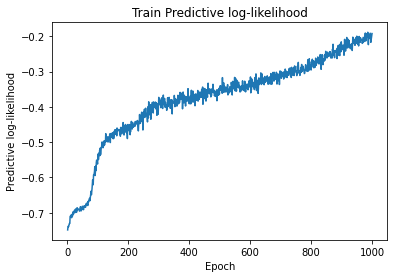

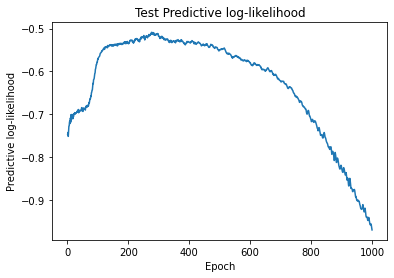




Activation Function : tanh 	Hidden Layer Size : 50 	Learning rate : 0.001

Epoch :  100 	 Training Loss : 0.4992 	 Training Accuracy : 79.20%
Epoch :  100 	 Training Loss : 0.4678 	 Training Accuracy : 79.26%
Epoch :  200 	 Training Loss : 0.4369 	 Training Accuracy : 81.40%
Epoch :  200 	 Training Loss : 0.4295 	 Training Accuracy : 80.32%
Epoch :  300 	 Training Loss : 0.4189 	 Training Accuracy : 81.80%
Epoch :  300 	 Training Loss : 0.4560 	 Training Accuracy : 79.79%
Epoch :  400 	 Training Loss : 0.4197 	 Training Accuracy : 82.00%
Epoch :  400 	 Training Loss : 0.4392 	 Training Accuracy : 80.32%
Epoch :  500 	 Training Loss : 0.4332 	 Training Accuracy : 81.40%
Epoch :  500 	 Training Loss : 0.3888 	 Training Accuracy : 82.98%
Epoch :  600 	 Training Loss : 0.4102 	 Training Accuracy : 82.00%
Epoch :  600 	 Training Loss : 0.4111 	 Training Accuracy : 81.38%
Epoch :  700 	 Training Loss : 0.4110 	 Training Accuracy : 81.40%
Epoch :  700 	 Training Loss : 0.3561 	 Training Ac

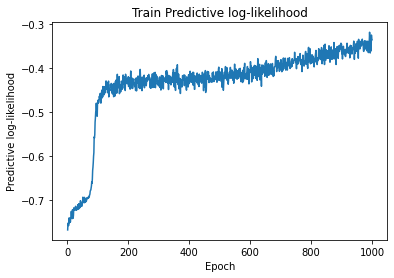

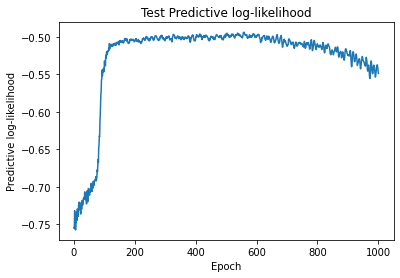

In [12]:
train_filename= "heart_train.csv"
test_filename = "heart_test.csv"

train_data    = BankData(train_filename)
train_loader  = torch.utils.data.DataLoader(dataset= train_data,  batch_size= train_batch_size, shuffle= True , num_workers = workers)

test_data     = BankData(test_filename)
test_loader   = torch.utils.data.DataLoader(dataset= test_data,  batch_size= test_batch_size, shuffle= False, num_workers = workers)
n_hidden_val = [50]
activation_val = ['relu', 'tanh']
for activation in activation_val:
    for n_hidden in n_hidden_val:
        net = BayesianNetwork(n_hidden= n_hidden, activation= activation).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr = lr)
        print("\n\n==============================================================================\n")
        print("Activation Function : {} \tHidden Layer Size : {} \tLearning rate : {}\n".format(activation, n_hidden, lr))
        train_like = []
        test_like = []
        for epoch in range(1,max_epoch+1):
            train(net, train_loader, optimizer, epoch)
            train_like.append(predictive_log_likelihood(net, train_loader).cpu())
            test_like.append(predictive_log_likelihood(net, test_loader).cpu())
        pred_acc = predictive_accuracy(net, test_loader)
        pred_like = predictive_log_likelihood(net, test_loader)
        print("\n Predictive Accuracy : {:.4f} \tPredictive Log Likelihood : {:.4f}".format(pred_acc, pred_like))

        plt.plot(np.arange(max_epoch)+1, train_like)
        plt.title("Train Predictive log-likelihood")
        plt.xlabel("Epoch")
        plt.ylabel("Predictive log-likelihood")
        plt.show()
        
    
        plt.plot(np.arange(max_epoch) + 1, test_like)
        plt.title("Test Predictive log-likelihood")
        plt.xlabel("Epoch")
        plt.ylabel("Predictive log-likelihood")
        plt.show()

cuda



Activation Function : relu 	Hidden Layer Size : 50 	Learning rate : 0.001



/tmp/ipykernel_621540/1123339618.py:197: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(x).astype(np.float)
/tmp/ipykernel_621540/1123339618.py:199: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y).astype(np.float)


Epoch :  100 	 Training Loss : 0.6872 	 Training Accuracy : 55.23%
Epoch :  200 	 Training Loss : 0.5266 	 Training Accuracy : 80.09%
Epoch :  300 	 Training Loss : 0.4682 	 Training Accuracy : 82.41%
Epoch :  400 	 Training Loss : 0.4463 	 Training Accuracy : 82.85%

 Predictive Accuracy : 77.9348 	Predictive Log Likelihood : -0.5265


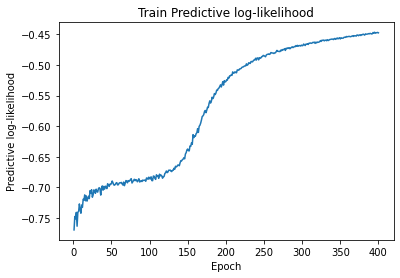

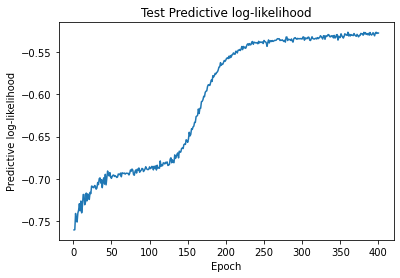




Activation Function : tanh 	Hidden Layer Size : 50 	Learning rate : 0.001

Epoch :  100 	 Training Loss : 0.7010 	 Training Accuracy : 55.23%
Epoch :  200 	 Training Loss : 0.5187 	 Training Accuracy : 77.03%
Epoch :  300 	 Training Loss : 0.4429 	 Training Accuracy : 81.40%
Epoch :  400 	 Training Loss : 0.4338 	 Training Accuracy : 81.10%

 Predictive Accuracy : 77.5696 	Predictive Log Likelihood : -0.5044


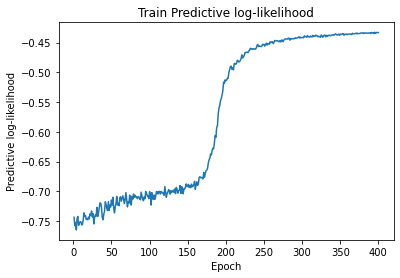

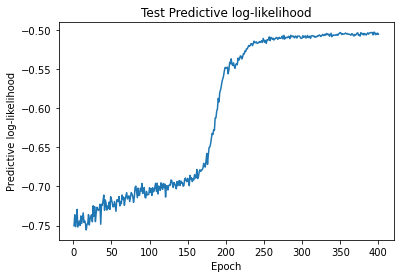

In [13]:
max_epoch       = 400
workers         = 4
train_batch_size= 900
test_batch_size = 500
log_iter        = 100

TOLERANCE    = 1e-5
input_dim    = 9
n_class      = 2
SAMPLES      = 100
TEST_SAMPLES = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

lr         = 0.001
n_hidden   = 50
activation = 'relu'

train_filename= "heart_train.csv"
test_filename = "heart_test.csv"

train_data    = BankData(train_filename)
train_loader  = torch.utils.data.DataLoader(dataset= train_data,  batch_size= train_batch_size, shuffle= True , num_workers = workers)

test_data     = BankData(test_filename)
test_loader   = torch.utils.data.DataLoader(dataset= test_data,  batch_size= test_batch_size, shuffle= False, num_workers = workers)
n_hidden_val = [50]
activation_val = ['relu', 'tanh']
for activation in activation_val:
    for n_hidden in n_hidden_val:
        net = BayesianNetwork(n_hidden= n_hidden, activation= activation).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr = lr)
        print("\n\n==============================================================================\n")
        print("Activation Function : {} \tHidden Layer Size : {} \tLearning rate : {}\n".format(activation, n_hidden, lr))
        train_like = []
        test_like = []
        for epoch in range(1,max_epoch+1):
            train(net, train_loader, optimizer, epoch)
            train_like.append(predictive_log_likelihood(net, train_loader).cpu())
            test_like.append(predictive_log_likelihood(net, test_loader).cpu())
        pred_acc = predictive_accuracy(net, test_loader)
        pred_like = predictive_log_likelihood(net, test_loader)
        print("\n Predictive Accuracy : {:.4f} \tPredictive Log Likelihood : {:.4f}".format(pred_acc, pred_like))

        plt.plot(np.arange(max_epoch)+1, train_like)
        plt.title("Train Predictive log-likelihood")
        plt.xlabel("Epoch")
        plt.ylabel("Predictive log-likelihood")
        plt.show()
        
    
        plt.plot(np.arange(max_epoch) + 1, test_like)
        plt.title("Test Predictive log-likelihood")
        plt.xlabel("Epoch")
        plt.ylabel("Predictive log-likelihood")
        plt.show()